<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
!pip install torchinfo

import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torchvision
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import clear_output
from pathlib import Path
from PIL import Image
import gc
from torchinfo import summary
import pandas as pd
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)



## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

> Ссылка для скачивания на момент выполнения задания недоступна. В работе использовался Flickr-Faces-HQ Dataset на 70 000 картинок (128х128)
> https://www.kaggle.com/datasets/greatgamedota/ffhq-face-data-set

In [ ]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and width of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object
    """

    # TODO: resize images, convert them to tensors and build dataloader

    custom_transforms = tt.Compose([
        tt.ToTensor(),
        # tt.Resize(image_size), # Images already resized to 128x128
        tt.Normalize((0.5202, 0.4252, 0.3803), (0.2771, 0.2511, 0.2520))])

    root = Path("/kaggle/input/ffhq-face-data-set/")

    # Create dataset
    dataset = ImageFolder(root, transform = custom_transforms)

    # Create dataloader
    loader = DataLoader(
        dataset,
        shuffle = True,
        batch_size = batch_size,
        num_workers = 2,
        drop_last = True)

    return loader

# --------------------
#       Helpers
# --------------------

# Show N images
def show(images, title = "Flickr Faces", figsize = (6,6)):
    fig = plt.figure(figsize = figsize)
    plt.axis('off')
    plt.title(title, fontsize = 20, fontweight = 'bold')
    grid = make_grid(images, normalize = True).permute(1,2,0)
    plt.imshow(grid)
    plt.show()

# Plot GAN loss each epoch
def plot(data):

    if isinstance(data, dict):
        d_loss = data['discriminator_loss']
        g_loss = data['generator_loss']
        epochs = data['epochs']
    else:
        raise TypeError("Incorrect input type: {}".format(type(data)))

    fig = plt.figure(figsize = (12, 6))
    sns.set(style = 'ticks', font_scale = 1.4)
    max_loss = max(d_loss + g_loss)
    min_loss = min(d_loss + g_loss)
    plt.plot(g_loss, label = 'Generator loss', c = '#359ba1', lw = 2.5)
    plt.plot(d_loss, label = 'Discriminator loss', c = '#113a40', lw = 2.5)
    plt.scatter(0, d_loss[0], s = 20, c = '#113a40')
    plt.scatter(0, g_loss[0], s = 20, c = '#359ba1')
    plt.xlim(-1, epochs + 1)
    plt.ylim(min_loss - min_loss / 10, max_loss + max_loss / 10)
    plt.title("Learning curve", fontsize = 18)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.show()

# Save model and losses
def save(model, optimizer, res, epoch):

    torch.save({
        'discriminator': model['discriminator'].state_dict(),
        'opt_d': optimizer['discriminator'].state_dict(),
        'generator' : model['generator'].state_dict(),
        'opt_g' : optimizer['generator'].state_dict()
        }, f'models_at_epoch_{epoch}.pth')

    res_df = pd.DataFrame({
        'discriminator_loss' : res['discriminator_loss'],
        'generator_loss' : res['generator_loss'],
        'real_img_score' : res['real_images'],
        'fake_img_score' : res['fake_images'],
        'fooled_img_score' : res['fooled_images']})

    res_df.to_csv(f"losses_at_epoch_{epoch}.csv")

# Transfer dataloader to device
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

Image size: 3x128x128


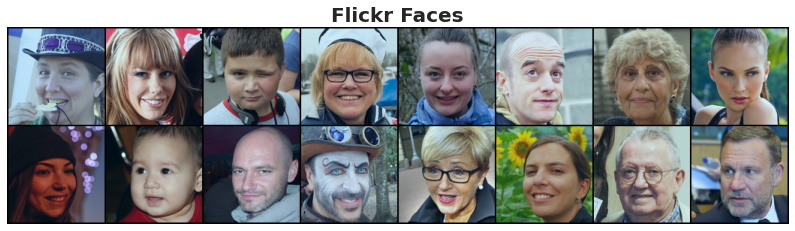

In [ ]:
#TODO: build dataloader and transfer it to device

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

image_size = (128, 128)
batch_size = 32

# Build loader
loader = get_dataloader(image_size, batch_size)

example, _ = next(iter(loader))
print("Image size: {}x{}x{}".format(example.shape[1], example.shape[2], example.shape[3]))

# Show first 16 images
show(example[:16], figsize = (14, 14))

# Transfer to device
loader = DeviceDataLoader(loader, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, True),

    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, True),

    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, True),

    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, True),

    nn.Conv2d(512, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, True),

    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.Sigmoid())


out = discriminator(example[:3]).detach()
assert max(out.shape[1:]) == 1, "Incorrect output shape: {}".format(out.shape)
print("Discriminator output: {} samples with size [{}]".format(out.size(0), out.size(1)))
summary(discriminator)


Discriminator output: 3 samples with size [1]


Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            3,072
├─BatchNorm2d: 1-2                       128
├─LeakyReLU: 1-3                         --
├─Conv2d: 1-4                            131,072
├─BatchNorm2d: 1-5                       256
├─LeakyReLU: 1-6                         --
├─Conv2d: 1-7                            524,288
├─BatchNorm2d: 1-8                       512
├─LeakyReLU: 1-9                         --
├─Conv2d: 1-10                           2,097,152
├─BatchNorm2d: 1-11                      1,024
├─LeakyReLU: 1-12                        --
├─Conv2d: 1-13                           4,194,304
├─BatchNorm2d: 1-14                      1,024
├─LeakyReLU: 1-15                        --
├─Conv2d: 1-16                           8,192
├─Sigmoid: 1-17                          --
Total params: 6,961,024
Trainable params: 6,961,024
Non-trainable params: 0

In [ ]:
latent_size = 128 # choose latent size
test_z = torch.randn(batch_size, latent_size,1, 1, device = 'cpu')

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.Conv2d(64, 3, kernel_size = 3, stride = 1, padding = 1, bias = False),
    nn.Tanh())


side = np.sqrt(example.size(2) * example.size(3))
out = generator(test_z).detach()
side_out = np.sqrt(out.size(2) * out.size(3))
assert side == side_out, "Incorrect output: {}".format(out.shape)
print("Generator output: {} samples [{}x{}x{}]".format(out.size(0), out.size(1), out.size(2), out.size(3)))
summary(generator)

Generator output: 32 samples [3x128x128]


Layer (type:depth-idx)                   Param #
Sequential                               --
├─ConvTranspose2d: 1-1                   1,048,576
├─BatchNorm2d: 1-2                       1,024
├─ReLU: 1-3                              --
├─ConvTranspose2d: 1-4                   2,097,152
├─BatchNorm2d: 1-5                       512
├─ReLU: 1-6                              --
├─ConvTranspose2d: 1-7                   524,288
├─BatchNorm2d: 1-8                       256
├─ReLU: 1-9                              --
├─ConvTranspose2d: 1-10                  262,144
├─BatchNorm2d: 1-11                      256
├─ReLU: 1-12                             --
├─ConvTranspose2d: 1-13                  262,144
├─BatchNorm2d: 1-14                      256
├─ReLU: 1-15                             --
├─ConvTranspose2d: 1-16                  131,072
├─BatchNorm2d: 1-17                      128
├─ReLU: 1-18                             --
├─Conv2d: 1-19                           1,728
├─Tanh: 1-20              

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
def fit(model, dataloader, opt, loss_fns, epochs, return_results = False):

    report = {'discriminator_loss' : [], 'generator_loss' : [],
              'fake_images' : [], 'real_images' : [], 'fooled_images' : [],
              'epochs' : epochs}

    fixed_latent = torch.randn(16, latent_size, 1, 1, device = device)

    for epoch in range(epochs):

        gc.collect()
        torch.cuda.empty_cache()

        loss_epoch_d = []
        loss_epoch_g = []
        score_real = []
        score_fake = []
        score_fooled = []

        model['discriminator'].train()
        model['generator'].train()

        with tqdm(dataloader, desc = "Epoch: {}/{}".format(epoch, epochs)) as tbar:
            for idx, (images_real, _) in enumerate(tbar):

                labels_real = (0.05 * torch.rand(images_real.size(0), 1, device = device) + 0.95).view(-1)

                # -----------------
                #   Discriminator
                # -----------------
                opt['discriminator'].zero_grad()

                # Get predictions and loss for real images
                preds_real = model['discriminator'](images_real).view(-1)
                loss_real = loss_fns['discriminator'](preds_real, labels_real)

                # Get predictions and loss for fake images
                latent = torch.randn(images_real.size(0), latent_size, 1, 1, device = device)
                images_fake = model['generator'](latent)
                labels_fake = 0.05 * torch.rand(images_fake.size(0), device = device)

                preds_fake = model['discriminator'](images_fake.detach()).view(-1)
                loss_fake = loss_fns['discriminator'](preds_fake, labels_fake)

                # Backpropagation
                discriminator_loss = loss_real + loss_fake
                discriminator_loss.backward()
                opt['discriminator'].step()

                # -----------------
                #     Generator
                # -----------------
                opt['generator'].zero_grad()

                # Generate fake images
                latent = torch.randn(images_real.size(0), latent_size, 1, 1, device = device)
                images_fake = model['generator'](latent)

                preds = model['discriminator'](images_fake).view(-1)
                generator_loss = loss_fns['generator'](preds, labels_real)
                generator_loss.backward()
                opt['generator'].step()

                loss_epoch_d.append(discriminator_loss.item())
                loss_epoch_g.append(generator_loss.item())

                score_real.append(list(preds_real.detach().cpu().numpy()))
                score_fake.append(list(preds_fake.detach().cpu().numpy()))
                score_fooled.append(list(preds.detach().cpu().numpy()))

                tbar.set_postfix(discr_loss = np.mean(loss_epoch_d), gen_loss = np.mean(loss_epoch_g))


        loss_epoch_d = np.mean(loss_epoch_d)
        loss_epoch_g = np.mean(loss_epoch_g)

        score_real = np.mean(score_real)
        score_fake = np.mean(score_fake)
        score_fooled = np.mean(score_fooled)

        report['discriminator_loss'].append(loss_epoch_d)
        report['generator_loss'].append(loss_epoch_g)
        report['real_images'].append(score_real)
        report['fake_images'].append(score_fake)
        report['fooled_images'].append(score_fooled)

        # Predict
        with torch.no_grad():
            generated_images = model['generator'](fixed_latent)

        # Visualize
        clear_output(wait = True)
        show(generated_images.cpu(), figsize = (14, 14), title = "Generated Faces")
        plot(report)

        # Save model
        if epoch % 5 == 0:
            save(model, opt, report, epoch)

    if return_results:
        return report


In [ ]:
lr = 3e-4
wd = 1e-5
n_epochs = 30

models = {"discriminator": discriminator.to(device).apply(weights_init),
         "generator": generator.to(device).apply(weights_init)}

criterions = {"discriminator": nn.BCELoss(),
             "generator": nn.BCELoss()}
optimizers = {
    "discriminator" : torch.optim.AdamW(
        models['discriminator'].parameters(),
        lr = lr,
        betas=(0.5, 0.999),
        weight_decay = wd,
    ),

    "generator" : torch.optim.AdamW(
        models['generator'].parameters(),
        lr = lr,
        betas=(0.5, 0.999),
        weight_decay = wd,
    )}

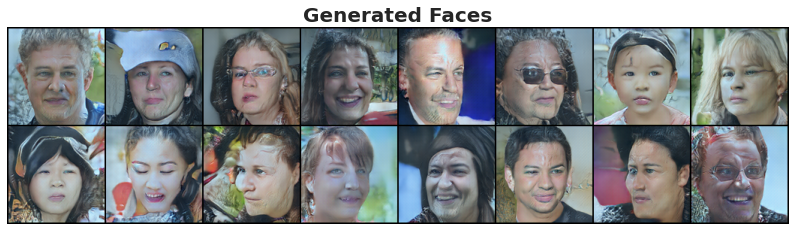

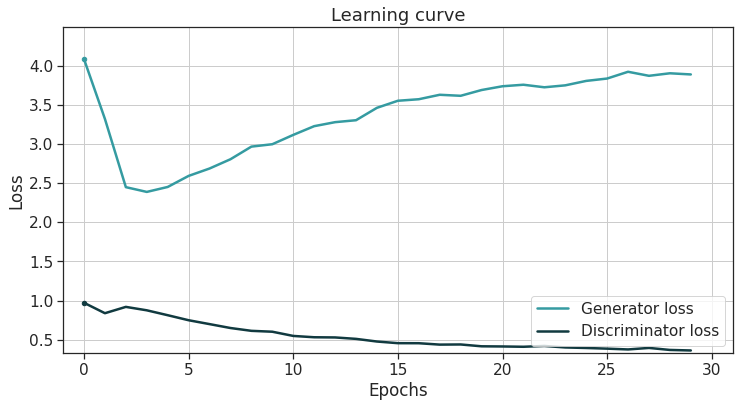

In [ ]:
losses = fit(models, loader, optimizers, criterions, n_epochs, return_results = True)

На 27 эпохе изображения выше выглядели очень реалистично, но к концу обучения качество визуально резко снизилось

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

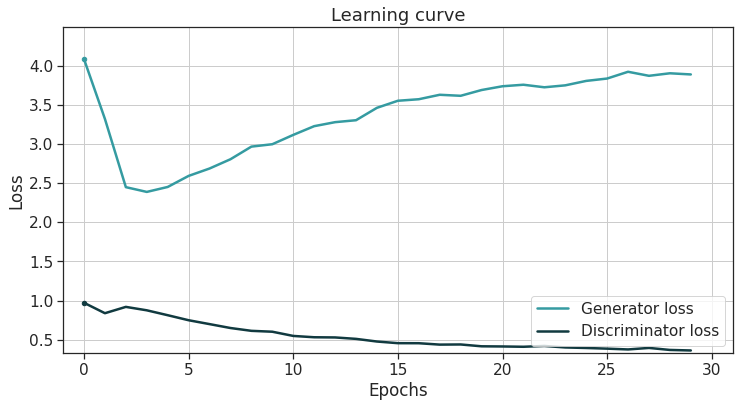

In [ ]:
plot(losses)

Дискриминатор и генератор соревнуются друг с другом. Когда ошибка одного увеличивается, ошибка другого уменьшается. В начале обучения функция потерь генератора уменьшается, а качество генерируемых изображений улучшается. После 3-4 эпохи дискриминатору становится проще отличать истинные изображения от сгенерированных и его ошибка постепенно уменьшается. Подобное поведение графиков примерно аналогично представленному в семинаре. Вероятно, времени обучения недостаточно для генерации более качественных фотографий, и после ~5 эпохи наблюдается единая тенденция к снижению ошибки дискриминатора и повышению ошибки генератора. Продолжение обучения скорее всего позволит достичь приемлемого качества на большинстве фейковых изображений.

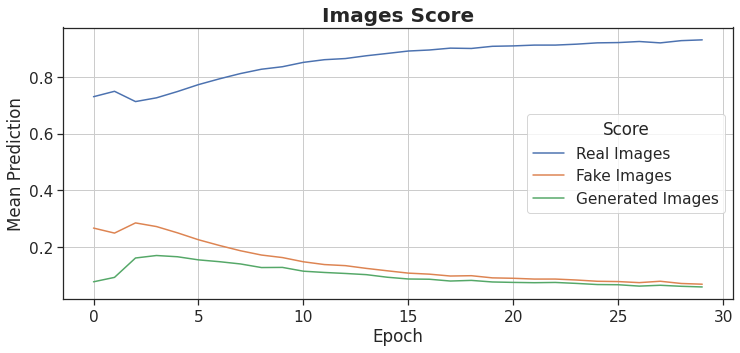

In [ ]:
fig = plt.subplots(figsize = (12, 5))
sns.set(style = 'ticks', font_scale = 1.4)

plt.plot(losses['real_images'], label = 'Real Images')
plt.plot(losses['fake_images'], label = 'Fake Images')
plt.plot(losses['fooled_images'], label = 'Generated Images')

plt.title("Images Score", fontweight = 'bold', fontsize = 20)
plt.xlabel("Epoch")
plt.ylabel("Mean Prediction")
plt.grid()
plt.legend(title = 'Score')
plt.show()

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
# checkpoint = torch.load('/kaggle/working/models_at_epoch_30')

# models['discriminator'].load_state_dict(checkpoint['discriminator'])
# models['generator'].load_state_dict(checkpoint['generator'])

<All keys matched successfully>

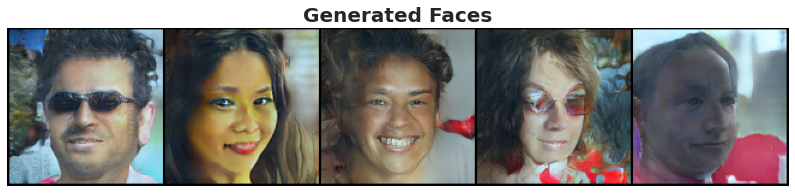

In [ ]:
n_images = 5
fixed_latent = torch.randn(n_images, latent_size,1, 1, device=device)

models['generator'].eval()
with torch.no_grad():
    generated_images = models['generator'](fixed_latent)

show(generated_images.cpu(), figsize = (14, 14), title = "Generated Faces")

**Как вам качество получившихся изображений?**

Иногда изображения выглядят очень правдоподобно. Качество на остальных оставляет желать лучшего, но генератор, безусловно, многому обучился

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
# Все 70000 изображений из обучающей выборки занимают больше оперативной памяти,
# чем доступно на Kaggle, поэтому было принято решение использовать только 2000 из них.

# True images preparation
img_count = 2000
true_images = torch.FloatTensor()
true_targets = torch.ones(img_count)
for images, _ in loader:
    if true_images.size(0) <= img_count:
        true_images = torch.cat((true_images, images), 0)
    else: break

# Fake images generation
models['generator'].eval().cpu()
gen_noise = torch.randn(img_count, latent_size, 1, 1, device = 'cpu')
gen_images = torch.FloatTensor()
gen_targets = torch.zeros(img_count)
for noise in gen_noise:
    gen_images = torch.cat((gen_images, models['generator'](noise.unsqueeze(0)).detach()), 0)

# Flattening
gen_images = gen_images.view(2000, -1)
true_images = true_images[:2000].view(2000, -1)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, classification_report

knn = KNeighborsClassifier(n_neighbors = 1, n_jobs = -1)
loo = LeaveOneOut()

predicted = []
classes = []
indexes = np.random.choice(img_count * 2, img_count * 2, replace = False) # shuffle

features = torch.cat((gen_images, true_images), 0)[indexes]
labels = torch.cat((gen_targets, true_targets))[indexes]

with tqdm(loo.split(features)) as tbar:
    for idx, (train_index, test_index) in enumerate(tbar):
        x_train, y_train = features[train_index], labels[train_index]
        x_test, y_test = features[test_index], labels[test_index]

        knn.fit(x_train, y_train)
        preds = knn.predict(x_test)
        proba = knn.predict_proba(x_test)[:, 1]

        predicted.append(int(preds[0]))
        classes.append(int(y_test.item()))

        tbar.set_postfix(acc_score = accuracy_score(classes, predicted))

4000it [3:22:19,  3.03s/it, acc_score=0.646]


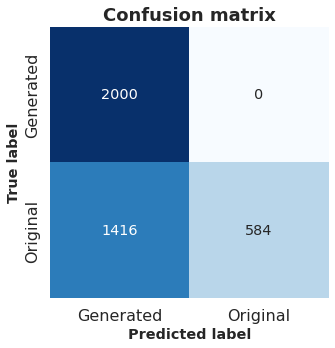

-----------------------------------------------------
			Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      2000
           1       1.00      0.29      0.45      2000

    accuracy                           0.65      4000
   macro avg       0.79      0.65      0.60      4000
weighted avg       0.79      0.65      0.60      4000



In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (5,5))
sns.heatmap(confusion_matrix(classes, predicted), annot = True, cbar = False, fmt = '.0f', cmap = 'Blues')
plt.xticks([0.5,1.5],['Generated', 'Original'], fontsize = 16)
plt.yticks([0.5, 1.5], ['Generated', 'Original'], fontsize = 16)
plt.title("Confusion matrix", fontweight = 'bold', fontsize = 18)
plt.xlabel("Predicted label", fontweight = 'bold')
plt.ylabel("True label", fontweight = 'bold')
plt.show()

print("-"*53)
print("\t\t\tReport")
print("-"*53)
print(classification_report(classes, predicted))

**Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?**

1NN оценивает распределение сгенерированных и истинных изображений.

Accuracy <0.5 говорит о переобучении GAN на входных изображениях и схожести генерируемых с обучающей выборкой. В самом крайнем случае accuracy = 0 и GAN генерирует идентичные с обучающей выборкой изображения

Accuracy >0.5 говорит о различии в распределении истинных и генерируемых изображений.

Наиболее оптимальной ситуацией является accuracy ~0.5. В таком случае 1NN плохо отличает сгенерированные изображения от настоящих, что говорит о их правдоподобности.

В моем случае accuracy составил 0.65. Этот результат говорит о небольшом различии в распределении истинных картинок и сгенерированных. Примечательно, что все сгенерированные картинки были правильно распознаны как сгенерированные, а >75% истинных предсказались как фейковые

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE
components = TSNE(n_components = 2, n_jobs = -1).fit_transform(features)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


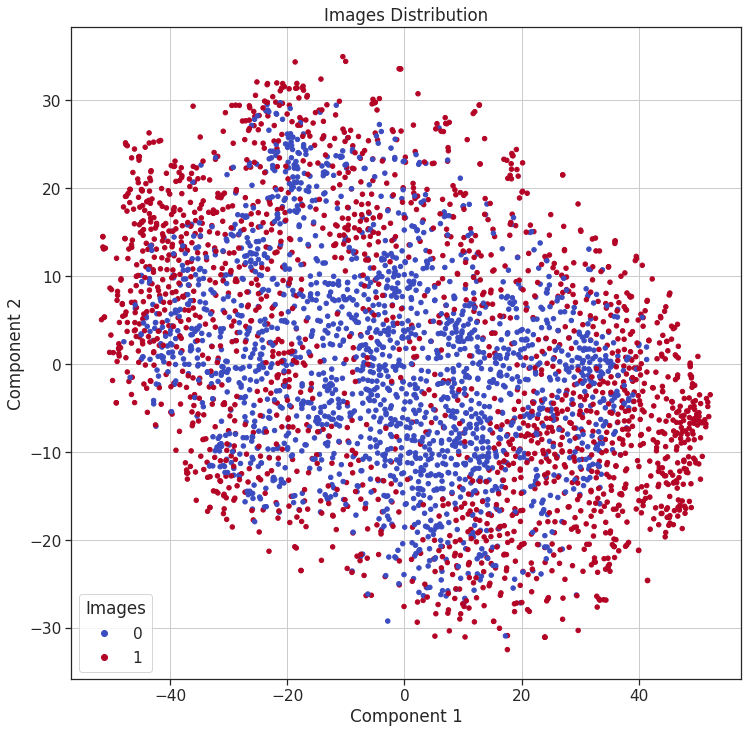

In [ ]:
fig = plt.figure(figsize = (12, 12))
sns.set(style = 'ticks', font_scale = 1.4)
scatter = plt.scatter(components[:, 0], components[:, 1], c = labels[:], s = 20,  cmap = 'coolwarm')
plt.legend(*scatter.legend_elements(), loc="lower left", title = 'Images')
plt.grid()
plt.title("Images Distribution")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

**Прокомментируйте получившийся результат:**

Изображения неплохо перемешаны, но некоторые различия в распределении присутствуют. Истинные картинки немного больше концентрируются на периферии, а сгенерированные в центре. В идеальном случае (accuracy ~0.5), точки в пространстве должны быть полностью перемешаны, без возможности визуально их разделить. Описанные в предыдущем пункте особенности 1NNС согласуются с визуализацией и полученной точностью